In [1]:
# Add parent folder to path, so that we can import local dh_modelling Python module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from pathlib import Path
import time

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dh_modelling.helpers import load_intermediate
from dh_modelling.evaluate import calculate_metrics

# Evaluating XGBoost model

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a recent architecture that is in many cases considered to be a good tool for building a model on tabular data, alongside with other gradient boosting methods (see e.g. [1], [2], [3], [4], [5], [6], [7], [8]). We will try to fit our model with XGBoost and see what level of error can we reach.

[Here](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f) is a thorough walk-through on hyperparameter tuning with XGBoost, we will use similar approach here.

The computations are done on a GPU, see [the documentation](https://xgboost.readthedocs.io/en/latest/gpu/index.html) on using GPU resources with XGBoost.


[1]: https://www.martinalarcon.org/2018-12-31-b-water-pumps/
[2]: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
[3]: https://www.quora.com/Does-supervised-deep-learning-work-better-than-XGBoost-on-tabular-data-when-you-have-loads-of-data
[4]: https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc
[5]: https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db
[6]: https://medium.com/kaggle-nyc/gradient-boosting-decision-trees-xgboost-vs-lightgbm-and-catboost-72df6979e0bb
[7]: https://towardsdatascience.com/lightgbm-vs-xgboost-which-algorithm-win-the-race-1ff7dd4917d
[8]: https://www.slideshare.net/odsc/owen-zhangopen-sourcetoolsanddscompetitions1

In [3]:
df_train_all = load_intermediate(Path(module_path)/'data/processed/train.feather')
df_train_all

,dh_MWh,Ilman lämpötila (degC),hour_of_day,day_of_week,day_of_year,epoch_seconds,is_business_day
date_time,,,,,,,
2015-01-01 01:00:00+02:00,936.000,4.0,1,3,1,1420066800,0
2015-01-01 02:00:00+02:00,924.200,4.1,2,3,1,1420070400,0
2015-01-01 03:00:00+02:00,926.300,4.2,3,3,1,1420074000,0
2015-01-01 04:00:00+02:00,942.100,3.6,4,3,1,1420077600,0
2015-01-01 05:00:00+02:00,957.100,3.3,5,3,1,1420081200,0
...,...,...,...,...,...,...,...
2019-10-20 10:00:00+03:00,677.137,8.8,10,6,293,1571554800,0
2019-10-20 11:00:00+03:00,648.368,10.0,11,6,293,1571558400,0
2019-10-20 12:00:00+03:00,627.489,10.8,12,6,293,1571562000,0


In [4]:
from sklearn.model_selection import train_test_split

X, y = df_train_all.drop("dh_MWh", axis=1), df_train_all[["dh_MWh"]]
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=.2, random_state=42)

Some starting-point parameters that have been found with initial iteration

In [5]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
deval = xgb.DMatrix(data=X_eval, label=y_eval)

# Original parameters
eval_metric = 'rmse'
num_boost_round = 2000
max_depth_range = [5,6,7]
min_child_weight_range = [2,3,4,5]

params = {
    # Static parameters, not tuned
    'objective':'reg:squarederror',
    'tree_method':'gpu_hist',
    'eval_metric':eval_metric,
    # Parameters that we are going to tune.
    'max_depth':max_depth_range[0],
    'min_child_weight': min_child_weight_range[0],
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}


model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, 'dtrain'), (deval, 'deval')],
    early_stopping_rounds=10,
)

[0]	dtrain-rmse:629.12592	deval-rmse:631.30176
[1]	dtrain-rmse:443.43012	deval-rmse:445.21936
[2]	dtrain-rmse:313.93631	deval-rmse:315.33374
[3]	dtrain-rmse:223.79620	deval-rmse:225.09802
[4]	dtrain-rmse:161.29596	deval-rmse:162.38165
[5]	dtrain-rmse:118.56077	deval-rmse:119.75821
[6]	dtrain-rmse:89.56086	deval-rmse:90.55431
[7]	dtrain-rmse:70.19821	deval-rmse:71.32149
[8]	dtrain-rmse:57.48982	deval-rmse:58.82520
[9]	dtrain-rmse:49.46176	deval-rmse:50.96102
[10]	dtrain-rmse:44.49338	deval-rmse:46.08794
[11]	dtrain-rmse:41.14482	deval-rmse:42.83064
[12]	dtrain-rmse:39.14993	deval-rmse:40.91832
[13]	dtrain-rmse:37.67110	deval-rmse:39.47581
[14]	dtrain-rmse:36.53205	deval-rmse:38.28644
[15]	dtrain-rmse:35.78735	deval-rmse:37.57539
[16]	dtrain-rmse:35.21998	deval-rmse:37.08302
[17]	dtrain-rmse:34.64458	deval-rmse:36.48888
[18]	dtrain-rmse:34.39811	deval-rmse:36.27731
[19]	dtrain-rmse:34.12119	deval-rmse:35.92517
[20]	dtrain-rmse:33.78269	deval-rmse:35.61068
[21]	dtrain-rmse:33.58643	deval-

[177]	dtrain-rmse:21.57571	deval-rmse:25.09749
[178]	dtrain-rmse:21.52508	deval-rmse:25.04930
[179]	dtrain-rmse:21.49151	deval-rmse:25.02217
[180]	dtrain-rmse:21.45462	deval-rmse:25.01352
[181]	dtrain-rmse:21.42843	deval-rmse:24.99787
[182]	dtrain-rmse:21.39431	deval-rmse:24.98457
[183]	dtrain-rmse:21.36705	deval-rmse:24.95965
[184]	dtrain-rmse:21.32644	deval-rmse:24.94599
[185]	dtrain-rmse:21.28101	deval-rmse:24.91740
[186]	dtrain-rmse:21.23321	deval-rmse:24.89797
[187]	dtrain-rmse:21.20591	deval-rmse:24.88470
[188]	dtrain-rmse:21.17784	deval-rmse:24.87188
[189]	dtrain-rmse:21.15946	deval-rmse:24.86033
[190]	dtrain-rmse:21.13011	deval-rmse:24.83831
[191]	dtrain-rmse:21.10462	deval-rmse:24.82017
[192]	dtrain-rmse:21.08498	deval-rmse:24.81053
[193]	dtrain-rmse:21.05254	deval-rmse:24.77457
[194]	dtrain-rmse:21.02737	deval-rmse:24.75859
[195]	dtrain-rmse:21.00917	deval-rmse:24.74503
[196]	dtrain-rmse:20.97938	deval-rmse:24.72299
[197]	dtrain-rmse:20.95806	deval-rmse:24.70411
[198]	dtrain-

[352]	dtrain-rmse:17.86227	deval-rmse:22.47320
[353]	dtrain-rmse:17.84257	deval-rmse:22.45925
[354]	dtrain-rmse:17.82980	deval-rmse:22.44963
[355]	dtrain-rmse:17.81829	deval-rmse:22.44302
[356]	dtrain-rmse:17.80064	deval-rmse:22.43526
[357]	dtrain-rmse:17.79309	deval-rmse:22.43198
[358]	dtrain-rmse:17.76563	deval-rmse:22.41352
[359]	dtrain-rmse:17.74598	deval-rmse:22.40387
[360]	dtrain-rmse:17.72272	deval-rmse:22.39477
[361]	dtrain-rmse:17.70255	deval-rmse:22.37803
[362]	dtrain-rmse:17.68489	deval-rmse:22.36662
[363]	dtrain-rmse:17.67205	deval-rmse:22.35811
[364]	dtrain-rmse:17.65491	deval-rmse:22.34329
[365]	dtrain-rmse:17.64263	deval-rmse:22.34290
[366]	dtrain-rmse:17.63641	deval-rmse:22.34078
[367]	dtrain-rmse:17.61762	deval-rmse:22.33673
[368]	dtrain-rmse:17.60303	deval-rmse:22.32992
[369]	dtrain-rmse:17.59154	deval-rmse:22.32314
[370]	dtrain-rmse:17.58513	deval-rmse:22.31979
[371]	dtrain-rmse:17.57419	deval-rmse:22.30275
[372]	dtrain-rmse:17.56917	deval-rmse:22.30260
[373]	dtrain-

[527]	dtrain-rmse:15.70929	deval-rmse:21.27032
[528]	dtrain-rmse:15.69406	deval-rmse:21.26738
[529]	dtrain-rmse:15.68242	deval-rmse:21.25642
[530]	dtrain-rmse:15.67128	deval-rmse:21.25153
[531]	dtrain-rmse:15.66684	deval-rmse:21.24731
[532]	dtrain-rmse:15.65443	deval-rmse:21.23740
[533]	dtrain-rmse:15.64421	deval-rmse:21.23873
[534]	dtrain-rmse:15.63305	deval-rmse:21.23748
[535]	dtrain-rmse:15.61910	deval-rmse:21.22911
[536]	dtrain-rmse:15.60786	deval-rmse:21.22415
[537]	dtrain-rmse:15.59825	deval-rmse:21.21972
[538]	dtrain-rmse:15.58892	deval-rmse:21.21340
[539]	dtrain-rmse:15.57404	deval-rmse:21.20404
[540]	dtrain-rmse:15.56566	deval-rmse:21.20050
[541]	dtrain-rmse:15.55190	deval-rmse:21.19509
[542]	dtrain-rmse:15.54779	deval-rmse:21.19474
[543]	dtrain-rmse:15.54292	deval-rmse:21.19105
[544]	dtrain-rmse:15.52572	deval-rmse:21.17974
[545]	dtrain-rmse:15.51273	deval-rmse:21.17469
[546]	dtrain-rmse:15.50827	deval-rmse:21.17147
[547]	dtrain-rmse:15.50629	deval-rmse:21.17085
[548]	dtrain-

[702]	dtrain-rmse:14.17763	deval-rmse:20.52923
[703]	dtrain-rmse:14.16680	deval-rmse:20.52626
[704]	dtrain-rmse:14.15878	deval-rmse:20.52018
[705]	dtrain-rmse:14.15354	deval-rmse:20.51491
[706]	dtrain-rmse:14.14451	deval-rmse:20.51231
[707]	dtrain-rmse:14.13557	deval-rmse:20.50728
[708]	dtrain-rmse:14.12507	deval-rmse:20.50657
[709]	dtrain-rmse:14.12349	deval-rmse:20.50598
[710]	dtrain-rmse:14.10734	deval-rmse:20.49907
[711]	dtrain-rmse:14.10075	deval-rmse:20.49494
[712]	dtrain-rmse:14.08983	deval-rmse:20.48838
[713]	dtrain-rmse:14.08485	deval-rmse:20.48576
[714]	dtrain-rmse:14.07542	deval-rmse:20.47801
[715]	dtrain-rmse:14.06874	deval-rmse:20.47670
[716]	dtrain-rmse:14.05522	deval-rmse:20.46891
[717]	dtrain-rmse:14.04710	deval-rmse:20.46848
[718]	dtrain-rmse:14.04117	deval-rmse:20.46932
[719]	dtrain-rmse:14.03480	deval-rmse:20.46774
[720]	dtrain-rmse:14.02689	deval-rmse:20.46020
[721]	dtrain-rmse:14.02057	deval-rmse:20.46024
[722]	dtrain-rmse:14.01793	deval-rmse:20.46061
[723]	dtrain-

[877]	dtrain-rmse:13.03797	deval-rmse:20.07323
[878]	dtrain-rmse:13.03214	deval-rmse:20.06988
[879]	dtrain-rmse:13.02160	deval-rmse:20.06696
[880]	dtrain-rmse:13.01660	deval-rmse:20.06514
[881]	dtrain-rmse:13.01238	deval-rmse:20.06354
[882]	dtrain-rmse:13.00715	deval-rmse:20.06733
[883]	dtrain-rmse:13.00307	deval-rmse:20.06311
[884]	dtrain-rmse:12.99453	deval-rmse:20.06312
[885]	dtrain-rmse:12.98366	deval-rmse:20.05788
[886]	dtrain-rmse:12.97365	deval-rmse:20.05326
[887]	dtrain-rmse:12.96626	deval-rmse:20.05172
[888]	dtrain-rmse:12.95792	deval-rmse:20.04890
[889]	dtrain-rmse:12.95538	deval-rmse:20.04925
[890]	dtrain-rmse:12.94813	deval-rmse:20.04691
[891]	dtrain-rmse:12.94149	deval-rmse:20.04812
[892]	dtrain-rmse:12.93444	deval-rmse:20.04662
[893]	dtrain-rmse:12.92988	deval-rmse:20.04501
[894]	dtrain-rmse:12.92736	deval-rmse:20.04594
[895]	dtrain-rmse:12.91981	deval-rmse:20.04226
[896]	dtrain-rmse:12.91443	deval-rmse:20.03475
[897]	dtrain-rmse:12.90991	deval-rmse:20.03437
[898]	dtrain-

In [6]:
print(f"Best {eval_metric}: {model.best_score:.2f} with {model.best_iteration+1} rounds")

Best rmse: 19.86 with 1006 rounds


In [7]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={eval_metric},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,629.207520,0.589613,629.173816,2.292000
1,443.493268,0.424034,443.453613,1.781020
2,313.949469,0.299870,313.906299,1.710757
3,223.820230,0.195102,223.838608,1.444365
4,161.300824,0.130614,161.501422,1.238529
...,...,...,...,...
1559,9.237994,0.071798,20.440236,0.277238
1560,9.234767,0.071495,20.440415,0.276784
1561,9.231662,0.071071,20.439892,0.277306
1562,9.227671,0.072275,20.439086,0.276975


In [8]:
cv_results[f"test-{eval_metric}-mean"].min()

20.436204599999996

In [9]:
# Parameters for first grid search - tree architecture
gridsearch_params = [
    {'max_depth':max_depth, 'min_child_weight':min_child_weight}
    for max_depth in max_depth_range
    for min_child_weight in min_child_weight_range
]

In [10]:
# Define initial best params and MAE

def cross_validate_best_metric(
    base_params: dict, gridsearch_params: dict,
    dtrain,
    seed,
    eval_metric: str,
    nfold: int  =5,
    num_boost_round: int = 200,
    early_stopping_rounds: int = 10
) -> tuple[dict, pd.DataFrame]:
    min_eval_metric = float("Inf")
    gs_eval_results = []

    best_params = None
    start_time = time.time()

    for i_round, gs_i_dict in enumerate(gridsearch_params):
        
        test_params = base_params.copy()
        test_params.update(gs_i_dict)

        print(f"Round {i_round+1}/{len(gridsearch_params)}; CV with additional parameters {gs_i_dict}")

        cv_results = xgb.cv(
            test_params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=seed,
            nfold=nfold,
            metrics={eval_metric},
            early_stopping_rounds=early_stopping_rounds
        )

        # Update best MAE
        mean_eval_metric = cv_results[f"test-{eval_metric}-mean"].min()
        boost_rounds = cv_results[f"test-{eval_metric}-mean"].argmin() + 1

        print(f"\t{eval_metric}={mean_eval_metric} for {boost_rounds} rounds")
        
        end_time = time.time()

        gs_eval_results.append(list(gs_i_dict.values()) + [mean_eval_metric, boost_rounds, end_time - start_time])
        start_time = end_time

        if mean_eval_metric < min_eval_metric:
            min_eval_metric = mean_eval_metric
            best_params = gs_i_dict

    print(f"Best param: {best_params}, {eval_metric}={min_eval_metric}")
    
    gs_eval_metric_df = pd.DataFrame(
        gs_eval_results,
        columns= list(gs_i_dict.keys()) + ['mean_eval_metric', 'boost_rounds', 'time']
    )
    gs_eval_metric_df.index.name = 'cv_round'
    
    final_params = base_params.copy()
    final_params.update(best_params)
    
    return final_params, gs_eval_metric_df

In [11]:
best_params, gs_eval_metric_df = cross_validate_best_metric(
    base_params=params,
    gridsearch_params=gridsearch_params,
    dtrain=dtrain,
    seed=42,
    eval_metric=eval_metric,
    num_boost_round=num_boost_round,
)

Round 1/12; CV with additional parameters {'max_depth': 5, 'min_child_weight': 2}
	rmse=20.436204599999996 for 1564 rounds
Round 2/12; CV with additional parameters {'max_depth': 5, 'min_child_weight': 3}
	rmse=20.3576042 for 1671 rounds
Round 3/12; CV with additional parameters {'max_depth': 5, 'min_child_weight': 4}
	rmse=20.277335 for 1799 rounds
Round 4/12; CV with additional parameters {'max_depth': 5, 'min_child_weight': 5}
	rmse=20.262773799999998 for 1804 rounds
Round 5/12; CV with additional parameters {'max_depth': 6, 'min_child_weight': 2}
	rmse=20.549431199999997 for 1174 rounds
Round 6/12; CV with additional parameters {'max_depth': 6, 'min_child_weight': 3}
	rmse=20.544613599999998 for 1029 rounds
Round 7/12; CV with additional parameters {'max_depth': 6, 'min_child_weight': 4}
	rmse=20.512489600000002 for 1155 rounds
Round 8/12; CV with additional parameters {'max_depth': 6, 'min_child_weight': 5}
	rmse=20.416288400000003 for 1448 rounds
Round 9/12; CV with additional pa

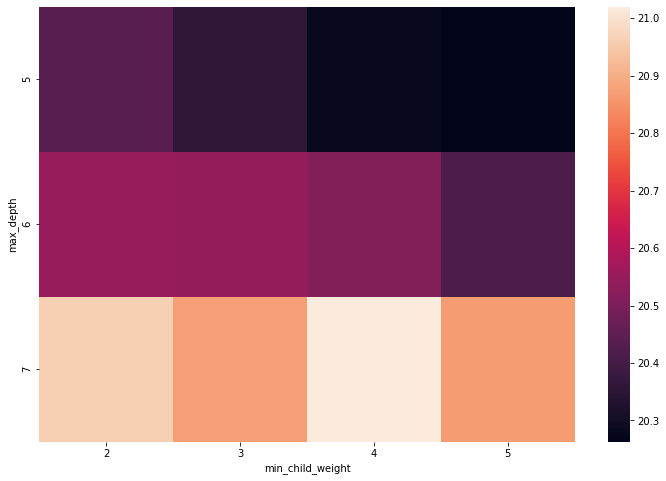

In [12]:
import seaborn as sns

metric_pivot = gs_eval_metric_df.pivot("max_depth", "min_child_weight", "mean_eval_metric")

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(metric_pivot)

fig.show()

In [13]:
params = best_params
params

{'objective': 'reg:squarederror',
 'tree_method': 'gpu_hist',
 'eval_metric': 'rmse',
 'max_depth': 5,
 'min_child_weight': 5,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1}

In [14]:
# Check out sampling parameters

gridsearch_params = [
    {'subsample':subsample, 'colsample_bytree':colsample}
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

best_params, gs_eval_metric_df = cross_validate_best_metric(
    base_params=params,
    gridsearch_params=gridsearch_params,
    dtrain=dtrain,
    seed=42,
    eval_metric=eval_metric,
    num_boost_round=num_boost_round,
)

Round 1/16; CV with additional parameters {'subsample': 0.7, 'colsample_bytree': 0.7}
	rmse=20.918339600000003 for 1261 rounds
Round 2/16; CV with additional parameters {'subsample': 0.7, 'colsample_bytree': 0.8}
	rmse=20.918339600000003 for 1261 rounds
Round 3/16; CV with additional parameters {'subsample': 0.7, 'colsample_bytree': 0.9}
	rmse=20.8110432 for 1108 rounds
Round 4/16; CV with additional parameters {'subsample': 0.7, 'colsample_bytree': 1.0}
	rmse=21.039886000000003 for 1099 rounds
Round 5/16; CV with additional parameters {'subsample': 0.8, 'colsample_bytree': 0.7}
	rmse=20.6768466 for 1336 rounds
Round 6/16; CV with additional parameters {'subsample': 0.8, 'colsample_bytree': 0.8}
	rmse=20.6768466 for 1336 rounds
Round 7/16; CV with additional parameters {'subsample': 0.8, 'colsample_bytree': 0.9}
	rmse=20.696059 for 962 rounds
Round 8/16; CV with additional parameters {'subsample': 0.8, 'colsample_bytree': 1.0}
	rmse=20.643867 for 1246 rounds
Round 9/16; CV with additio

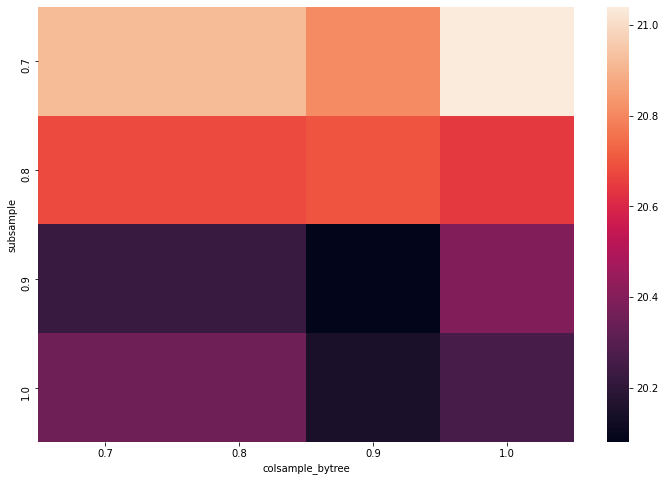

In [15]:
metric_pivot = gs_eval_metric_df.pivot("subsample", "colsample_bytree", "mean_eval_metric")

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(metric_pivot)

fig.show()

In [16]:
params = best_params
params

{'objective': 'reg:squarederror',
 'tree_method': 'gpu_hist',
 'eval_metric': 'rmse',
 'max_depth': 5,
 'min_child_weight': 5,
 'eta': 0.3,
 'subsample': 0.9,
 'colsample_bytree': 0.9}

In [17]:
# Eta tuning
gridsearch_params = [
    {'eta':eta}
    for eta in [.3, .2, .1, 0.05, 0.01]
]

best_params, gs_eval_metric_df = cross_validate_best_metric(
    base_params=params,
    gridsearch_params=gridsearch_params,
    dtrain=dtrain,
    seed=42,
    eval_metric=eval_metric,
    num_boost_round = num_boost_round * 3,
)

gs_eval_metric_df

Round 1/5; CV with additional parameters {'eta': 0.3}
	rmse=20.0809132 for 1554 rounds
Round 2/5; CV with additional parameters {'eta': 0.2}
	rmse=19.828991600000002 for 1923 rounds
Round 3/5; CV with additional parameters {'eta': 0.1}
	rmse=19.4120858 for 4353 rounds
Round 4/5; CV with additional parameters {'eta': 0.05}
	rmse=19.6197266 for 6000 rounds
Round 5/5; CV with additional parameters {'eta': 0.01}
	rmse=22.729838200000003 for 6000 rounds
Best param: {'eta': 0.1}, rmse=19.4120858


,eta,mean_eval_metric,boost_rounds,time
cv_round,,,,
0,0.30,20.080913,1554,13.894043
1,0.20,19.828992,1923,17.172222
2,0.10,19.412086,4353,39.184589
3,0.05,19.619727,6000,53.371023
4,0.01,22.729838,6000,53.829785


In [18]:
params = best_params
params

{'objective': 'reg:squarederror',
 'tree_method': 'gpu_hist',
 'eval_metric': 'rmse',
 'max_depth': 5,
 'min_child_weight': 5,
 'eta': 0.1,
 'subsample': 0.9,
 'colsample_bytree': 0.9}

In [19]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(deval, 'Evaluation')],
    early_stopping_rounds=10,
)

[0]	Evaluation-rmse:808.61304
[1]	Evaluation-rmse:730.46844
[2]	Evaluation-rmse:660.19134
[3]	Evaluation-rmse:594.91028
[4]	Evaluation-rmse:536.19781
[5]	Evaluation-rmse:483.40787
[6]	Evaluation-rmse:435.92044
[7]	Evaluation-rmse:393.27466
[8]	Evaluation-rmse:354.94229
[9]	Evaluation-rmse:320.50278
[10]	Evaluation-rmse:289.45309
[11]	Evaluation-rmse:261.57678
[12]	Evaluation-rmse:236.56833
[13]	Evaluation-rmse:214.05978
[14]	Evaluation-rmse:193.90785
[15]	Evaluation-rmse:175.80959
[16]	Evaluation-rmse:159.65240
[17]	Evaluation-rmse:145.14796
[18]	Evaluation-rmse:132.25722
[19]	Evaluation-rmse:120.65543
[20]	Evaluation-rmse:110.36712
[21]	Evaluation-rmse:101.22297
[22]	Evaluation-rmse:92.98953
[23]	Evaluation-rmse:85.78001
[24]	Evaluation-rmse:79.42181
[25]	Evaluation-rmse:73.73549
[26]	Evaluation-rmse:68.79781
[27]	Evaluation-rmse:64.39947
[28]	Evaluation-rmse:60.55212
[29]	Evaluation-rmse:57.23839
[30]	Evaluation-rmse:54.26382
[31]	Evaluation-rmse:51.72747
[32]	Evaluation-rmse:49.5539

[268]	Evaluation-rmse:25.81791
[269]	Evaluation-rmse:25.80119
[270]	Evaluation-rmse:25.78508
[271]	Evaluation-rmse:25.77001
[272]	Evaluation-rmse:25.75388
[273]	Evaluation-rmse:25.73210
[274]	Evaluation-rmse:25.72012
[275]	Evaluation-rmse:25.70991
[276]	Evaluation-rmse:25.69700
[277]	Evaluation-rmse:25.68827
[278]	Evaluation-rmse:25.67411
[279]	Evaluation-rmse:25.66049
[280]	Evaluation-rmse:25.63410
[281]	Evaluation-rmse:25.61756
[282]	Evaluation-rmse:25.60291
[283]	Evaluation-rmse:25.59458
[284]	Evaluation-rmse:25.58049
[285]	Evaluation-rmse:25.56194
[286]	Evaluation-rmse:25.54260
[287]	Evaluation-rmse:25.52068
[288]	Evaluation-rmse:25.51136
[289]	Evaluation-rmse:25.49830
[290]	Evaluation-rmse:25.48333
[291]	Evaluation-rmse:25.47848
[292]	Evaluation-rmse:25.45263
[293]	Evaluation-rmse:25.44920
[294]	Evaluation-rmse:25.43372
[295]	Evaluation-rmse:25.42548
[296]	Evaluation-rmse:25.41295
[297]	Evaluation-rmse:25.40476
[298]	Evaluation-rmse:25.38588
[299]	Evaluation-rmse:25.37097
[300]	Ev

[533]	Evaluation-rmse:23.12034
[534]	Evaluation-rmse:23.11873
[535]	Evaluation-rmse:23.11497
[536]	Evaluation-rmse:23.11265
[537]	Evaluation-rmse:23.10707
[538]	Evaluation-rmse:23.09980
[539]	Evaluation-rmse:23.09314
[540]	Evaluation-rmse:23.08452
[541]	Evaluation-rmse:23.08069
[542]	Evaluation-rmse:23.07345
[543]	Evaluation-rmse:23.06393
[544]	Evaluation-rmse:23.06156
[545]	Evaluation-rmse:23.05622
[546]	Evaluation-rmse:23.05344
[547]	Evaluation-rmse:23.05151
[548]	Evaluation-rmse:23.04582
[549]	Evaluation-rmse:23.03815
[550]	Evaluation-rmse:23.03156
[551]	Evaluation-rmse:23.02527
[552]	Evaluation-rmse:23.02165
[553]	Evaluation-rmse:23.01646
[554]	Evaluation-rmse:23.01135
[555]	Evaluation-rmse:23.00576
[556]	Evaluation-rmse:23.00159
[557]	Evaluation-rmse:22.98980
[558]	Evaluation-rmse:22.98160
[559]	Evaluation-rmse:22.97718
[560]	Evaluation-rmse:22.96807
[561]	Evaluation-rmse:22.96389
[562]	Evaluation-rmse:22.96282
[563]	Evaluation-rmse:22.95896
[564]	Evaluation-rmse:22.95151
[565]	Ev

[798]	Evaluation-rmse:21.84837
[799]	Evaluation-rmse:21.84446
[800]	Evaluation-rmse:21.84129
[801]	Evaluation-rmse:21.83821
[802]	Evaluation-rmse:21.83571
[803]	Evaluation-rmse:21.83408
[804]	Evaluation-rmse:21.83067
[805]	Evaluation-rmse:21.82970
[806]	Evaluation-rmse:21.82625
[807]	Evaluation-rmse:21.82239
[808]	Evaluation-rmse:21.81715
[809]	Evaluation-rmse:21.81180
[810]	Evaluation-rmse:21.81132
[811]	Evaluation-rmse:21.81067
[812]	Evaluation-rmse:21.80693
[813]	Evaluation-rmse:21.80350
[814]	Evaluation-rmse:21.79803
[815]	Evaluation-rmse:21.79540
[816]	Evaluation-rmse:21.78928
[817]	Evaluation-rmse:21.78173
[818]	Evaluation-rmse:21.77765
[819]	Evaluation-rmse:21.77299
[820]	Evaluation-rmse:21.76797
[821]	Evaluation-rmse:21.76331
[822]	Evaluation-rmse:21.76192
[823]	Evaluation-rmse:21.75838
[824]	Evaluation-rmse:21.75341
[825]	Evaluation-rmse:21.74946
[826]	Evaluation-rmse:21.73973
[827]	Evaluation-rmse:21.73676
[828]	Evaluation-rmse:21.73040
[829]	Evaluation-rmse:21.72821
[830]	Ev

[1061]	Evaluation-rmse:21.04290
[1062]	Evaluation-rmse:21.04245
[1063]	Evaluation-rmse:21.03571
[1064]	Evaluation-rmse:21.03370
[1065]	Evaluation-rmse:21.02945
[1066]	Evaluation-rmse:21.02769
[1067]	Evaluation-rmse:21.02543
[1068]	Evaluation-rmse:21.02169
[1069]	Evaluation-rmse:21.01930
[1070]	Evaluation-rmse:21.01795
[1071]	Evaluation-rmse:21.01482
[1072]	Evaluation-rmse:21.01222
[1073]	Evaluation-rmse:21.01183
[1074]	Evaluation-rmse:21.00944
[1075]	Evaluation-rmse:21.00500
[1076]	Evaluation-rmse:21.00239
[1077]	Evaluation-rmse:20.99900
[1078]	Evaluation-rmse:20.99788
[1079]	Evaluation-rmse:20.99686
[1080]	Evaluation-rmse:20.99389
[1081]	Evaluation-rmse:20.99087
[1082]	Evaluation-rmse:20.98960
[1083]	Evaluation-rmse:20.98861
[1084]	Evaluation-rmse:20.98772
[1085]	Evaluation-rmse:20.98781
[1086]	Evaluation-rmse:20.97926
[1087]	Evaluation-rmse:20.97675
[1088]	Evaluation-rmse:20.97372
[1089]	Evaluation-rmse:20.97066
[1090]	Evaluation-rmse:20.97030
[1091]	Evaluation-rmse:20.96665
[1092]	E

[1318]	Evaluation-rmse:20.47321
[1319]	Evaluation-rmse:20.47326
[1320]	Evaluation-rmse:20.47066
[1321]	Evaluation-rmse:20.47223
[1322]	Evaluation-rmse:20.46691
[1323]	Evaluation-rmse:20.46479
[1324]	Evaluation-rmse:20.45859
[1325]	Evaluation-rmse:20.45554
[1326]	Evaluation-rmse:20.45282
[1327]	Evaluation-rmse:20.44779
[1328]	Evaluation-rmse:20.44769
[1329]	Evaluation-rmse:20.44677
[1330]	Evaluation-rmse:20.44586
[1331]	Evaluation-rmse:20.44241
[1332]	Evaluation-rmse:20.44040
[1333]	Evaluation-rmse:20.43749
[1334]	Evaluation-rmse:20.43655
[1335]	Evaluation-rmse:20.43618
[1336]	Evaluation-rmse:20.43552
[1337]	Evaluation-rmse:20.43354
[1338]	Evaluation-rmse:20.43346
[1339]	Evaluation-rmse:20.43279
[1340]	Evaluation-rmse:20.43305
[1341]	Evaluation-rmse:20.43287
[1342]	Evaluation-rmse:20.43112
[1343]	Evaluation-rmse:20.42850
[1344]	Evaluation-rmse:20.42823
[1345]	Evaluation-rmse:20.42640
[1346]	Evaluation-rmse:20.42249
[1347]	Evaluation-rmse:20.42143
[1348]	Evaluation-rmse:20.42109
[1349]	E

[1575]	Evaluation-rmse:20.03508
[1576]	Evaluation-rmse:20.03360
[1577]	Evaluation-rmse:20.03160
[1578]	Evaluation-rmse:20.02653
[1579]	Evaluation-rmse:20.02590
[1580]	Evaluation-rmse:20.02451
[1581]	Evaluation-rmse:20.02313
[1582]	Evaluation-rmse:20.02183
[1583]	Evaluation-rmse:20.01906
[1584]	Evaluation-rmse:20.01751
[1585]	Evaluation-rmse:20.01606
[1586]	Evaluation-rmse:20.01339
[1587]	Evaluation-rmse:20.01352
[1588]	Evaluation-rmse:20.01282
[1589]	Evaluation-rmse:20.01284
[1590]	Evaluation-rmse:20.00977
[1591]	Evaluation-rmse:20.00866
[1592]	Evaluation-rmse:20.00635
[1593]	Evaluation-rmse:20.00357
[1594]	Evaluation-rmse:20.00297
[1595]	Evaluation-rmse:20.00300
[1596]	Evaluation-rmse:20.00158
[1597]	Evaluation-rmse:20.00278
[1598]	Evaluation-rmse:20.00287
[1599]	Evaluation-rmse:20.00118
[1600]	Evaluation-rmse:20.00086
[1601]	Evaluation-rmse:19.99751
[1602]	Evaluation-rmse:19.99831
[1603]	Evaluation-rmse:19.99972
[1604]	Evaluation-rmse:19.99696
[1605]	Evaluation-rmse:19.99711
[1606]	E

[1832]	Evaluation-rmse:19.74024
[1833]	Evaluation-rmse:19.73951
[1834]	Evaluation-rmse:19.73740
[1835]	Evaluation-rmse:19.73801
[1836]	Evaluation-rmse:19.73628
[1837]	Evaluation-rmse:19.73491
[1838]	Evaluation-rmse:19.73381
[1839]	Evaluation-rmse:19.73214
[1840]	Evaluation-rmse:19.73105
[1841]	Evaluation-rmse:19.73088
[1842]	Evaluation-rmse:19.72836
[1843]	Evaluation-rmse:19.72860
[1844]	Evaluation-rmse:19.72731
[1845]	Evaluation-rmse:19.72877
[1846]	Evaluation-rmse:19.72886
[1847]	Evaluation-rmse:19.72881
[1848]	Evaluation-rmse:19.72891
[1849]	Evaluation-rmse:19.72944
[1850]	Evaluation-rmse:19.72792
[1851]	Evaluation-rmse:19.72787
[1852]	Evaluation-rmse:19.72555
[1853]	Evaluation-rmse:19.72261
[1854]	Evaluation-rmse:19.72170
[1855]	Evaluation-rmse:19.72106
[1856]	Evaluation-rmse:19.72041
[1857]	Evaluation-rmse:19.71929
[1858]	Evaluation-rmse:19.72054
[1859]	Evaluation-rmse:19.72029
[1860]	Evaluation-rmse:19.71879
[1861]	Evaluation-rmse:19.71596
[1862]	Evaluation-rmse:19.71532
[1863]	E

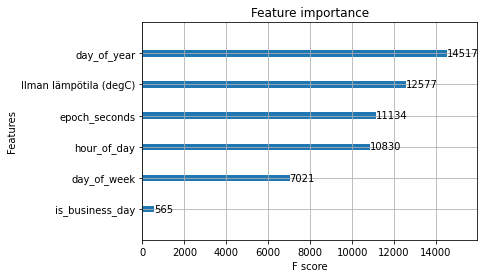

In [20]:
xgb.plot_importance(model)
plt.show()

As expected, ambient temperature is the most important feature, followed by date parameters,
most importantly hour-of-day

## Saving the model

In [21]:
boost_rounds_best_model = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=boost_rounds_best_model,
)

In [22]:
# Metrics on the evaluation dataset
calculate_metrics(y_eval.squeeze().to_numpy(), best_model.predict(deval))

{'mean_absolute_error': 14.135081126200951,
 'mean_absolute_percentage_error': 0.023204058787955357,
 'root_mean_squared_error': 19.564876545400658}

In [23]:
best_model.save_model("xgboost_mae.model")

## Model testing

Let's load test dataframe and check how the model works

In [24]:
df_test = load_intermediate(Path(module_path)/'data/processed/test.feather')
X_test, y_test = df_test.drop("dh_MWh", axis=1), df_test[["dh_MWh"]]

dtest = xgb.DMatrix(data=X_test, label=y_test)

predicted = best_model.predict(dtest)
actual = y_test.squeeze().to_numpy()

calculate_metrics(actual, predicted)

{'mean_absolute_error': 51.32177609189702,
 'mean_absolute_percentage_error': 0.09196250295243708,
 'root_mean_squared_error': 64.24041639015734}

**It is clear that the test model developed by train/eval datasets does not really work on test dataset.**

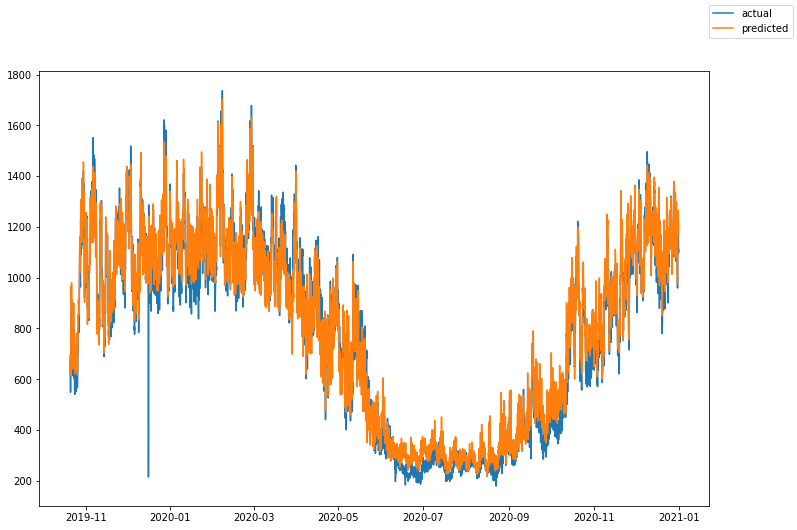

In [25]:
fig = plt.figure(figsize=(12,8))
# plt.plot(df_train.index, df_train['dh_MWh'], label='train')
plt.plot(df_test.index, actual, label='actual')
plt.plot(df_test.index, predicted, label='predicted')
fig.legend()

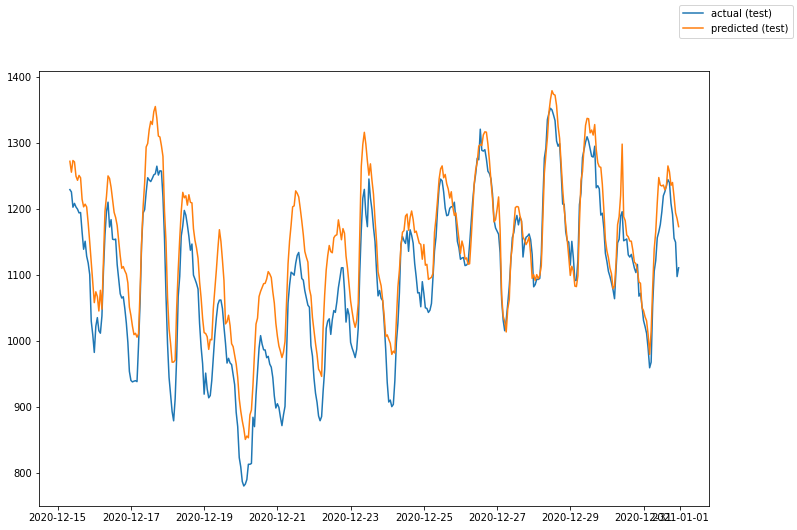

In [26]:
last_hours = 400

fig = plt.figure(figsize=(12,8))
plt.plot(df_test.index[-last_hours:], actual[-last_hours:], label='actual (test)')
plt.plot(df_test.index[-last_hours:], predicted[-last_hours:], label='predicted (test)')
fig.legend()

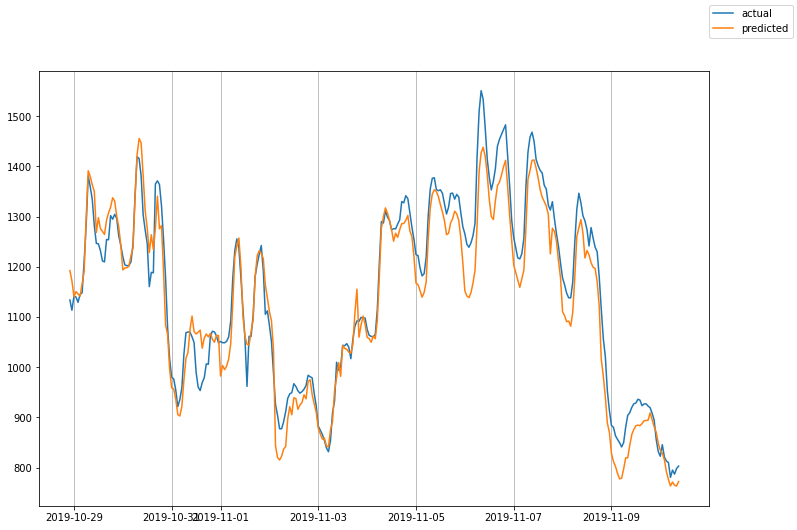

In [27]:
idx = slice(200,500)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_test.index[idx], actual[idx], label='actual')
ax.plot(df_test.index[idx], predicted[idx], label='predicted')
ax.xaxis.grid()
fig.legend()

It seems, that here we fail to follow the actual generation.

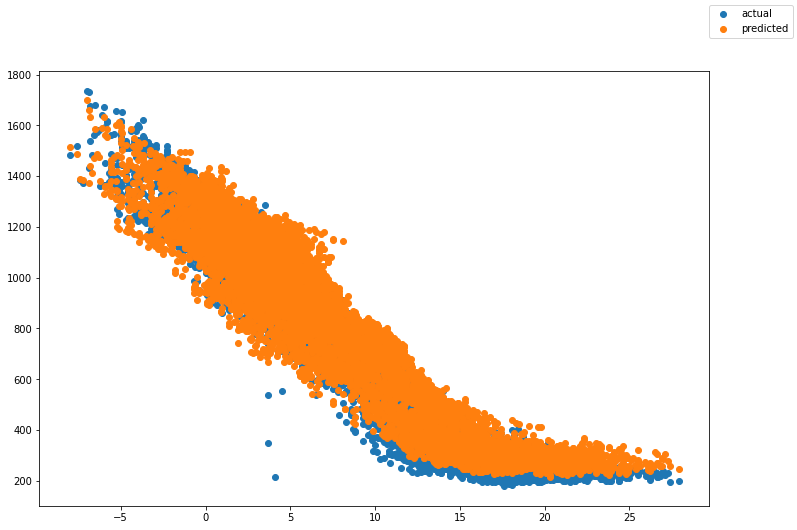

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x=X_test["Ilman lämpötila (degC)"], y=actual, label='actual')
ax.scatter(x=X_test["Ilman lämpötila (degC)"], y=predicted, label='predicted')
fig.legend()
plt.show()

The predictions seem to underestimate variance, and generally, to underestimate generation.

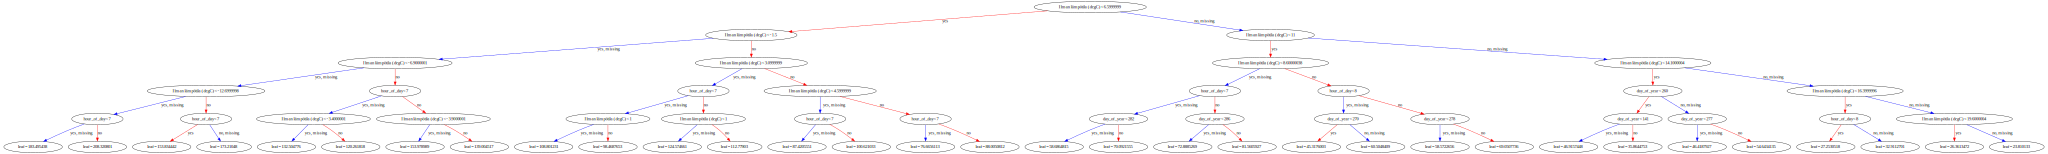

In [29]:
xgb.to_graphviz(best_model)

## When do errors occur?

<AxesSubplot:xlabel='hour_of_day', ylabel='error'>

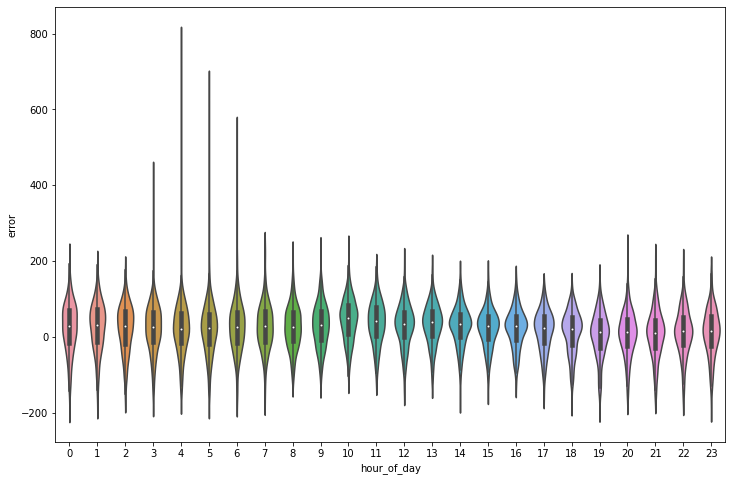

In [30]:
test_orig = load_intermediate(Path(module_path)/'data/processed/test.feather')
test_orig['error'] = pd.Series(predicted - actual).values
test_orig

import seaborn as sns

fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(data=test_orig, x='hour_of_day', y='error', ax=ax)

At least we have to seek for better prediction during hours 3-6.
Experimentation showed (not displayed here) that sin-encoding of hour_of_day does not really affect this outcome.

One possible explanation might be that the DH storages are loaded during the night hours, when consumption is low and electricity prices are usually also lower. This needs to be investigated.

Possible features to add to the dataset:
- spot electricity price
- DH generation lag, cumulative generation from previous ~1-6 hours
- ambient temperature lead, average ambient temperature gradient for the next ~1-6 hours

<AxesSubplot:xlabel='month', ylabel='error'>

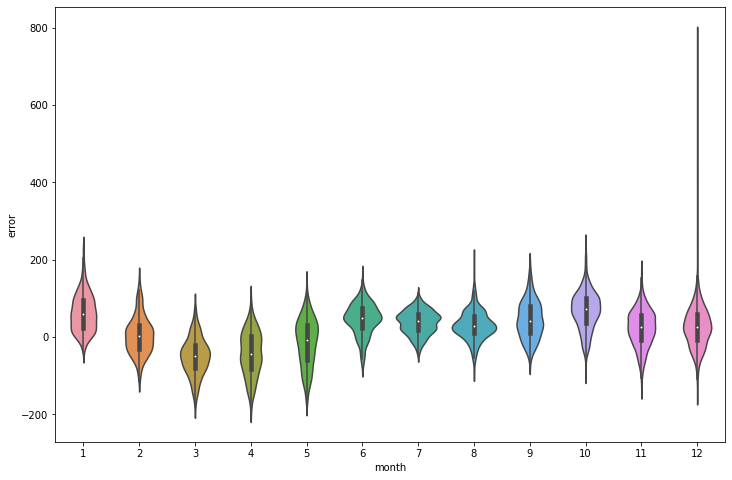

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
test_orig['month'] = test_orig.index.month
sns.violinplot(data=test_orig, x='month', y='error', ax=ax)

The outlier in 2019-12 is clearly visible over there. In general, there is more error during the colder season. The DH consumption is also lower in the summer, so that is not a big surprise.

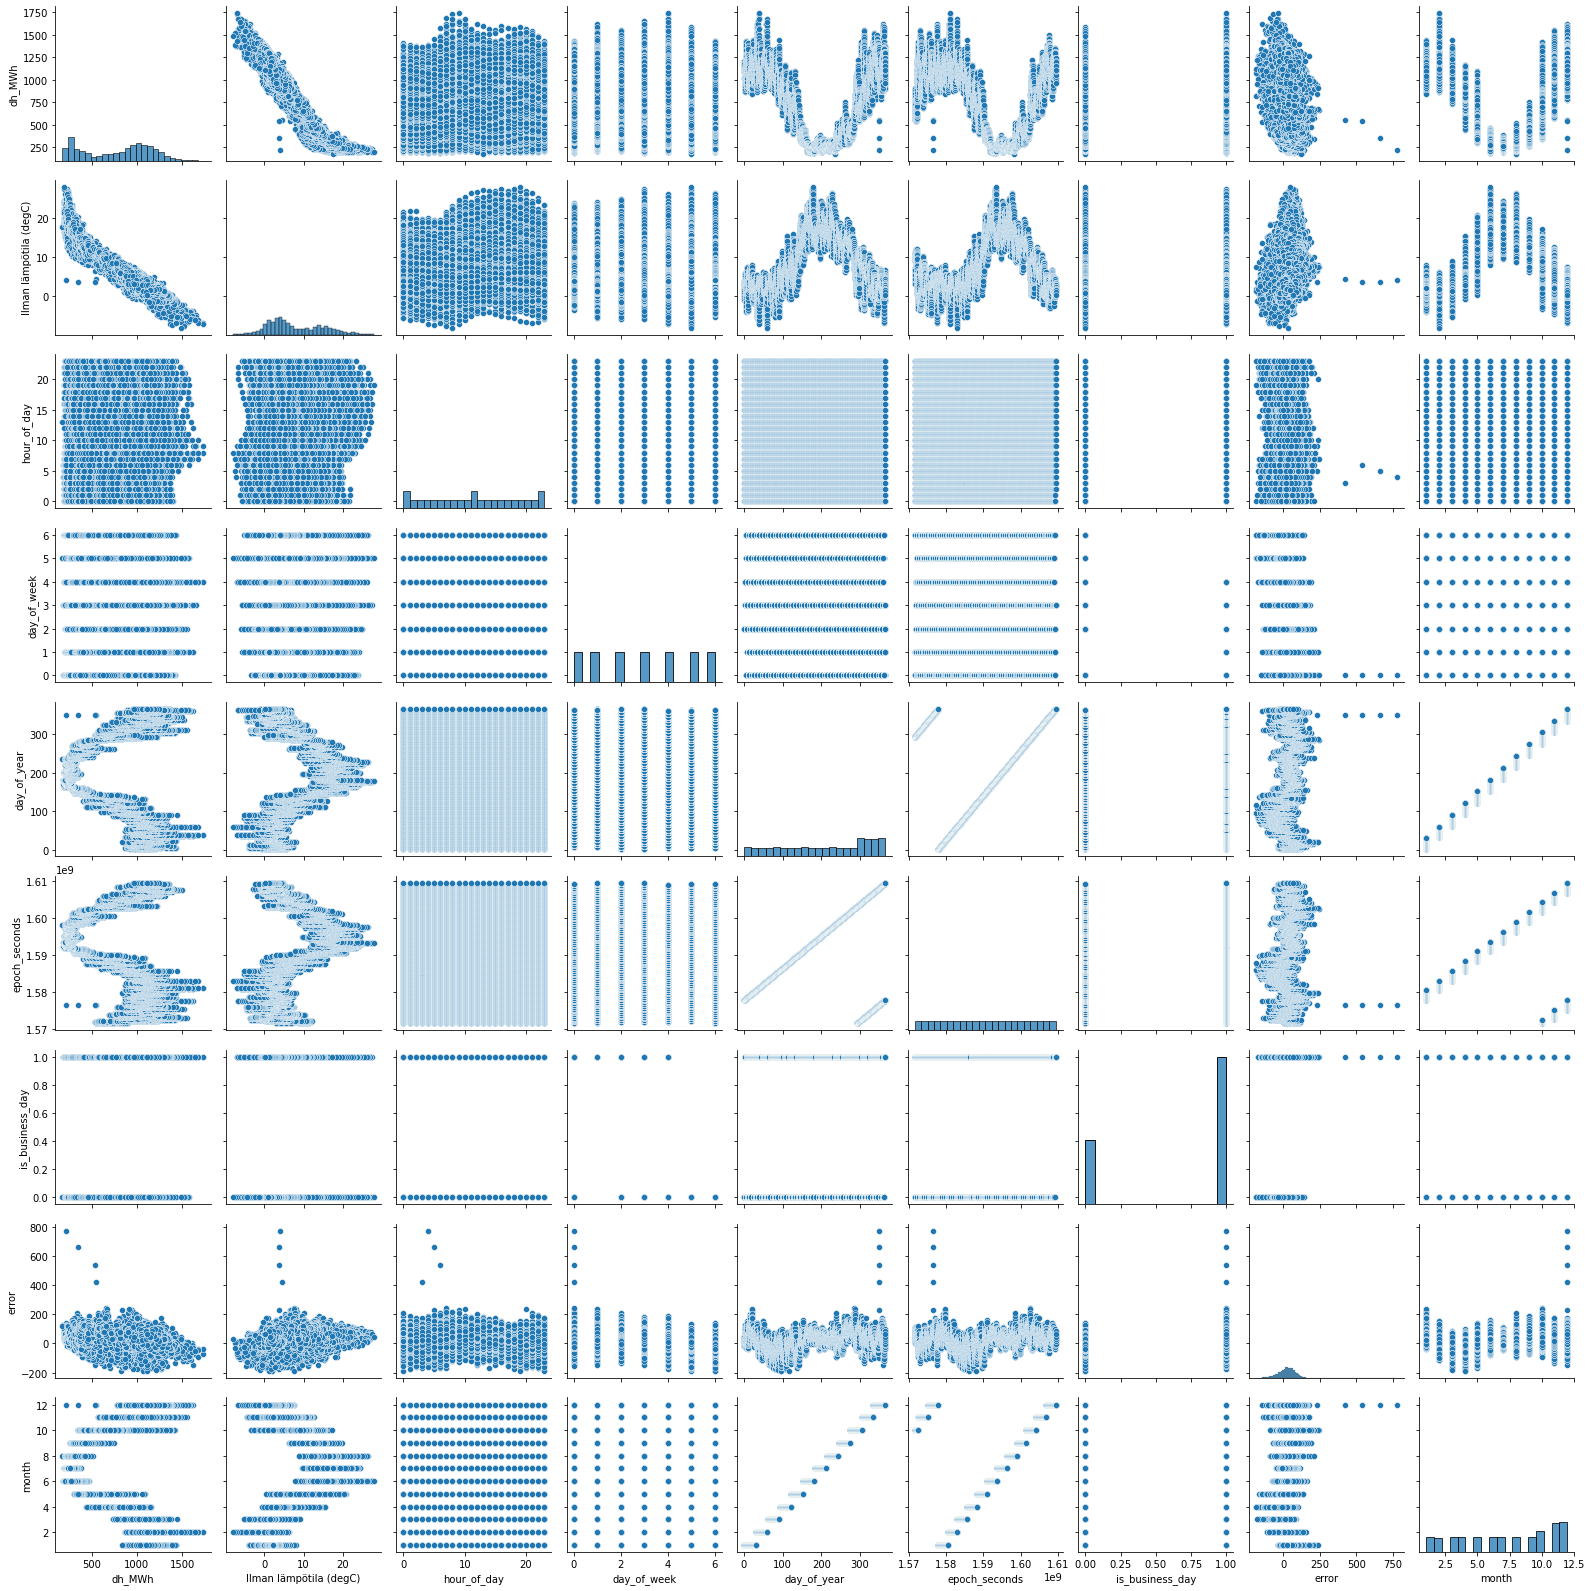

In [32]:
sns.pairplot(test_orig)

In [33]:
calculate_metrics(actual, predicted)

{'mean_absolute_error': 51.32177609189702,
 'mean_absolute_percentage_error': 0.09196250295243708,
 'root_mean_squared_error': 64.24041639015734}

In [34]:
greatest_error_indices = np.argsort(np.abs(test_orig['error']))[::-1]
greatest_error_indices

date_time
2020-12-31 23:00:00+02:00    1358
2020-12-31 22:00:00+02:00    1359
2020-12-31 21:00:00+02:00    1360
2020-12-31 20:00:00+02:00    1357
2020-12-31 19:00:00+02:00    8584
                             ... 
2019-10-20 19:00:00+03:00    4806
2019-10-20 18:00:00+03:00    1828
2019-10-20 17:00:00+03:00     814
2019-10-20 16:00:00+03:00    5357
2019-10-20 15:00:00+03:00    9215
Name: error, Length: 10522, dtype: int64

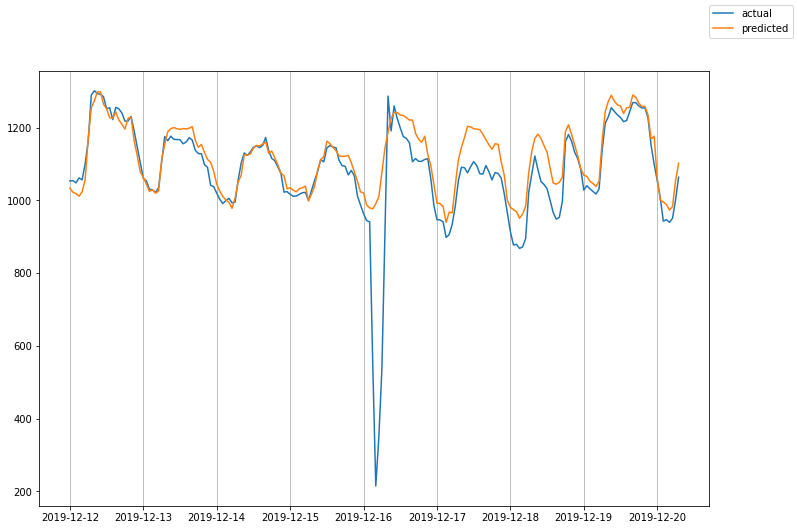

In [35]:
def plot_error_location(order, error_indices, delta=100):
    i = error_indices[order]
    idx = slice(i-delta,i+delta)

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(df_test.index[idx], actual[idx], label='actual')
    ax.plot(df_test.index[idx], predicted[idx], label='predicted')
    ax.xaxis.grid()
    fig.legend()
    return fig

fig = plot_error_location(0, greatest_error_indices)
plt.show()

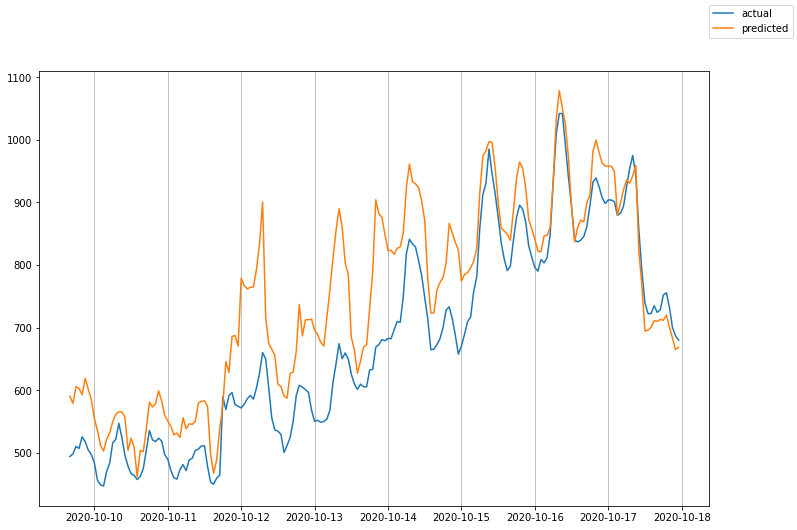

In [36]:
fig = plot_error_location(5, greatest_error_indices)
plt.show()